Created by Jason Chen, under Professor Krzysztof Fidkowski

# Problem Statement
The quality and runtime of a CFD solution is highly dependent on the mesh, and although good methods exist to automate mesh refinement, initial mesh generation techiques remain poor at capturing where refinement should take place, and to what degree. The goal of this project is to replicate and build off of work done by [Ohja, Chen, and Fidkowski](https://websites.umich.edu/~kfid/MYPUBS/Ojha_Chen_Fidkowski_2022.pdf), which performs anisotropic mesh generation on simple 2D airfoils. The subsequent mesh optimization process (typically done by routines like MOESS) is out of the scope of this project.

| ![run1_mesh.png](/home/jasonyc/code/research/ml-meshing/images/run1_mesh.png) | 
|:--:| 
| **Figure 1:** A near-optimally meshed airfoil used for training. |

# Background
Anisotropy, meaning when the elements in the mesh are noncongruent, is represented mathematically by a **metric field**. A metric field can be thought of as a measuring stick—it defines distances between points in space, or more precisely (paraphrasing from the cited paper above), for a metric field $M$ and a point in space $\vec{x}$, $M(\vec{x})$ measures the distance from $\vec{x}$ to a point infinitesimally far away, $\vec{x} + \delta \vec{x}$.

Since our problem is in 2 dimensions, $M$ is represented by a 2x2 SPD (symmetric positive definite) matrix. To break down this definition:

- **Symmetric**: $M = M^T$
- **Positive Definite**: The eigenvalues of the metric are all real and positive, meaning the matrix's behavior is "well-defined" and thus there are no directions $x$ where $x^T M x \leq 0$

## Measuring Distance
As an aside, we'll dive into why and how $x^T M x$ represents a distance. I've taken Math 419 but I found that I needed to brush up on linear algebra for this. Feel free to skip this section.

Firstly, how do we define the notion of length for a vector? We take the dot product of the vector with itself:
$$ \vec{x} \cdot \vec{x} = \lVert {\vec{x}} \rVert^2 $$
We can rewrite this:
$$ x^T x = x^T I x = \lVert {\vec{x}} \rVert^2 $$
Here, $I$ is the identity matrix. Thus, it implies that a metric such that $M = I$ is our "typical" notion of distance, without the local stretching.

The expression $x^T M x$ is also called a **quadratic form**:
$$ x^T M x = \sum_{i,j}^{} M_{i,j} x_i x_j $$
which combines the components of $x$ using $M$, and can be used to represent a polynomial using matrices. For example, given that:
$$ M = \begin{bmatrix}
3 & -2 \\
-2 & 7
\end{bmatrix} $$
we can compute:
$$
x^T M x = \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix}
3 & -2 \\
-2 & 7
\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
$$
$$
= 3 x_1 x_1 - 2 x_1 x_2 - 2 x_2 x_1 + 7 x_2 x_2 = 3 x_1^2 - 4 x_1 x_2 + 7 x_2^2
$$

We can see that if $M$ is a diagonal matrix, i.e. $M = \lambda_i I$, the cross product term (involving both $x_1$ and $x_2$) does not exist and we are left with the square of the components times $\lambda_i$. In other words, each component $x_i$ is scaled by the corresponding eigenvalue $\lambda_i$:
$$ x^T M x = \lambda_1 x_1^2 + \lambda_2 x_2^2 + ... $$

In the more general case, take an SPD matrix $M$. The eigenvalues of $M$ represent the magnitude of scaling (shrinking or stretching, as seen above), and will not result in negative distances since $\lambda_i > 0$ by definition of SPD. The eigenvectors will represent the principal directions of this scaling. 

We can show this mathematically through diagonalization. Since $M$ is symmetric, we can diagonalize it:
$$ M = SDS^{-1} $$
More specifically, because $M$ is real and symmetric, $S$ is an orthogonal matrix, i.e. its columns contain linearly independent vectors (eigenvectors of $M$) and $S$ exhibits the property that $S^{-1} = S^T$. $D$ is a diagonal matrix with each entry being the eigenvalues of $M$.

Next, we can express $x$ in the new basis (defined by the eigenvectors of $M$) with:
$$ y = S^T x $$
This is a simple change of basis. Since each column of S contains eigenvectors, $S^T x$ essentially computes the dot product of each basis vector with $x$, and so $y$ represents $x$ in the new basis. We can then substitute $x = Sy$ in, noting that $S^T S = S^{-1} S = I$:
$$ x^T M x = (Sy)^T (S D S^{-1}) (Sy) = y^T S^T S D S^{-1} S y = y^T D y$$
Since $D$ is diagonal, this simplifies to:
$$ x^T M x = y^T D y = \sum_{i=1}^{n} \lambda_i y_i^2 $$
and so the quadratic form $x^T M x$ measures a **generalized squared distance** in the transformed space.

## Metric Fields Applied to Meshing
Since a metric field represents stretching along the axes of its eigenvectors, if we plot a set of points a unit distance away from a certain point $\vec{x}$ with metric $M$, we will get an ellipse. The direction of the major and minor axes are given by the eigenvectors, and the length of each axis (stretching) is the inverse square root of the corresponding eigenvalue. This means we can visualize the metric fields given a mesh, but first, we'll need to understand how we are encoding the mesh data.

### Mesh Data Format
Meshes are given in `.gri` files under the `meshes/` directory. Within these files, the first section (first couple hundred lines) give two numbers separated by a space, which are $(x,y)$ pairs of coordinates representing a node. This section ends once a following line in the file looks something like this: `52 2 Outflow`. This is a boundary label, which calls out edges that define boundary conditions when running FEA/CFD, but are not necessarily useful right now. The section that defines our elements follows a label that looks like: `1670 1 TriLagrange`. "Trilagrange" is the key word to look out for here, and we can note that the data following this label is a set of three integers. Each integer corresponds with a node, which was numbered (indexed) when we ingested the first section at the beginning of the file. These three nodes together define a triangular element.

## Plotting Ellipses
So, we can ingest the `.gri` file and plot the mesh using `plotmesh.py` (implementation and derivation will be skipped here since it's pretty tedious but relatively straightforward). To plot the metric field ellipses corresponding with each element, we perform the following routine:

**Assumptions**

- The metric field is constant across an element
- Each node of an element is a unit distance (1) away from each other, i.e. the edges (denoted $\delta \vec{x}$) have length 1 as defined by the local metric field $M$

**Routine**

- Go through all elements
- For each element, get the (x,y) coordinates of each of its 3 nodes
- Compute the edge vectors by simple vector subtraction $\delta \vec{x}$
- For each edge, we have the equation $1 = \delta \vec{x}^T M \delta \vec{x}$ where M is the unknown 2x2 metric field with entries $(a, b, b, c)$
- Since we have three edges, we will have 3 equations and 3 unknowns, and solve
- Once we have the metric field, compute its eigenvalues and eigenvectors, and plot the ellipse

The code below is a copy of the file `plotmesh.py`, for demonstration purposes.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from readgri import readgri


def plot_metric_fields(mesh: dict, ax: plt.Axes):
    """
    Plot the metric field ellipses. This function relies in the dictionaries
    for elements and vertices to already be filled by the `readgri.py` module.
    """
    V = mesh['V']; E = mesh['E']
    for i, element in enumerate(E):
        # Each vertex contains three (x,y) tuple coordinates
        verts = [V[v_ind] for v_ind in element]
        centroid = np.asarray([np.mean([v[0] for v in verts]),
                               np.mean([v[1] for v in verts])])
        delta_x = [verts[i] - verts[i-1] for i in range(len(verts))]
        # Assemble a matrix of the quadratic form for each edge
        A_mat = [[vec[0]**2, 2*vec[0]*vec[1], vec[1]**2] for vec in delta_x]
        A_mat = np.reshape(np.asarray(A_mat), (3,3))
        # Solve the system of equations by inverting A
        soln_abc = np.matmul(np.linalg.inv(A_mat), np.ones((3,1))).flatten()
        M_mat = np.array([[soln_abc[0], soln_abc[1]],
                          [soln_abc[1], soln_abc[2]]])
        # Extract eigenvalues and eigenvectors and plot
        eig_vals, eig_vecs = np.linalg.eig(M_mat)
        major_ax_i = np.argmax(eig_vals)
        minor_ax_i = int(not major_ax_i)
        axes_scales = np.zeros(len(eig_vals))
        axes_scales[major_ax_i] = eig_vals[major_ax_i]**(-1/2)
        axes_scales[minor_ax_i] = eig_vals[minor_ax_i]**(-1/2)
        # Angle of the major axis with the global (plotting) coordinate frame
        angle_major = np.arctan2(eig_vecs[major_ax_i][1],
                                 eig_vecs[major_ax_i][0])
        if i % 10 == 0:  # Only plotting every 10th ellipse here
            plt.scatter(centroid[0], centroid[1], color='red', alpha=0.5, s=2)
            ellipse = Ellipse(centroid, axes_scales[major_ax_i],
                              axes_scales[minor_ax_i],
                              angle=-angle_major*180/np.pi,
                              facecolor='blue', alpha=0.5)
            ax.add_patch(ellipse)


def plotmesh(mesh: dict):
    """
    Plot the mesh itself. This also calls the metric field plotting function.
    """
    V = mesh['V']; E = mesh['E']; BE = mesh['BE']
    fig, ax = plt.subplots(dpi=200)
    plt.triplot(V[:,0], V[:,1], E, 'k-')
    for i in range(BE.shape[0]):
        plt.plot(V[BE[i,0:2],0], V[BE[i,0:2],1], linewidth=1, color='black')
    plot_metric_fields(mesh, ax)
    ax = plt.gca()
    ax.set_xlim([-1, 2])
    ax.set_ylim([-2, 2])
    plt.tick_params(axis='both')
    plt.show()
    plt.close(fig)

Now, we'll run the plotting routine. We're ingesting the `.gri` file specified with `file_name`, which is the same file as shown in Figure 1.

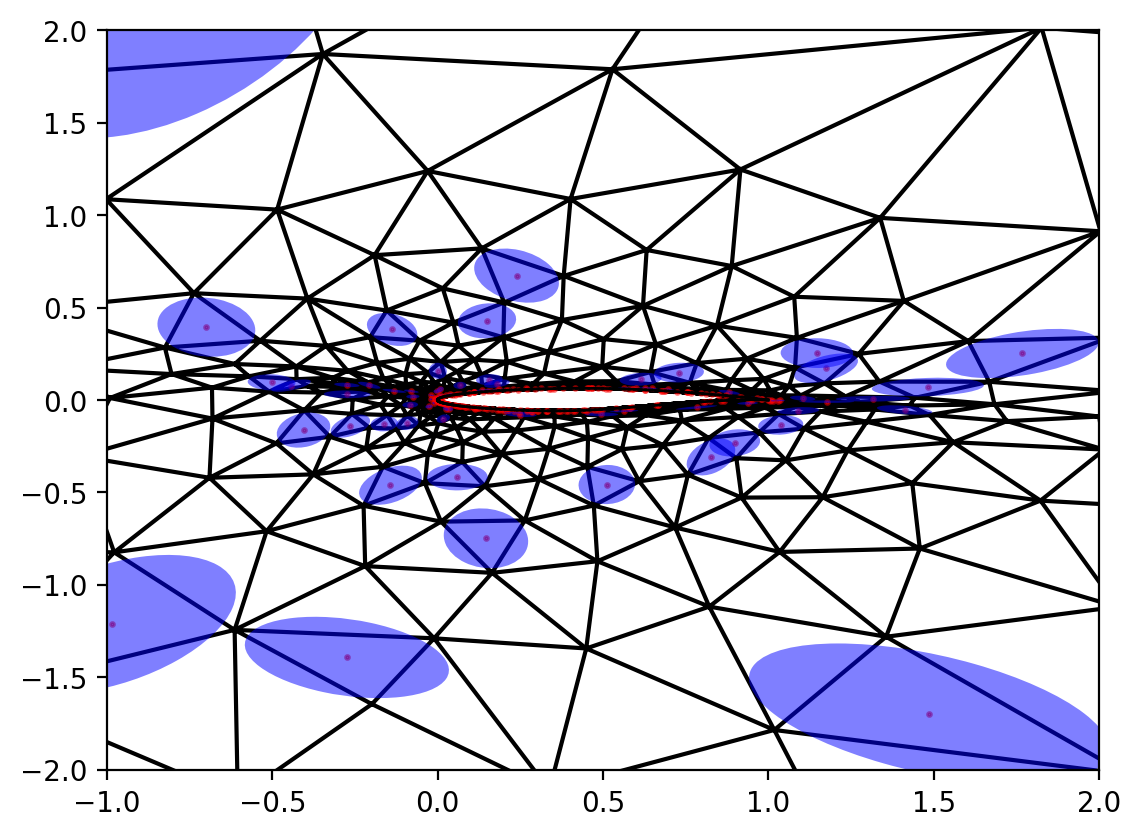

In [15]:
file_name = 'meshes/run1.gri'
plt.style.use('fast')
mesh = readgri(file_name)
plotmesh(mesh)